# Training

Is the play will paly longer than 6 months? 

Backgound

    More than half of the game players (55.2%) stop playing the game within a month. The remaining 44.8% of players continue playing for two to twelve months. The goal of this experiment is to identify the gamers who are likely to churn and offer them a discounted subscription to retain them longer. Since there are subscriptions for 1, 3 and 6 months, we want to target the players who are likely to quit after a month and offer them a 6-month subscription with a discount, hoping that they will play beyond 6-8 months and reach 9-12 months.


![](./images/pie_bar_play_duration_in_month.png)

In [1]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score, roc_curve, RocCurveDisplay, mean_absolute_error

In [2]:
wow_players = pd.read_parquet("./data/play_recordes.parquet").reset_index().drop("char", axis=1)
wow_players.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration,Jan,...,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Orc,38,2,Hunter,63.127588,593,1,54,12,461.0,...,65.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,668.0,522.0
1,Orc,43,2,Hunter,70.000000,1504,1,70,6,771.0,...,502.0,354.0,46.0,122.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Orc,31,1,Hunter,50.602446,550,7,29,5,0.0,...,0.0,0.0,0.0,0.0,139.0,52.0,477.0,620.0,20.0,0.0
3,Orc,24,3,Rogue,69.983255,1710,1,69,12,1195.0,...,757.0,778.0,615.0,243.0,41.0,0.0,0.0,0.0,0.0,50.0
4,Orc,50,2,Hunter,70.000000,863,1,70,12,367.0,...,163.0,36.0,91.0,67.0,204.0,399.0,80.0,326.0,155.0,123.0


Remove 'Death Knight' class and level lower than 20 because

- Death Knight is released on October, so the maximum preiod of the game play for the charcter can't be long than two month
- Level 20 or lower play game for free

In [3]:
wow_players = wow_players.query("charclass != 'Death Knight' and level > 20")
wow_players["avg_playcnt_month"] = wow_players["playcount"] / wow_players["playduration"]
wow_players = wow_players.drop(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], axis=1)

Add column to indicate players who play the game less than 6 months for classification


In [4]:
wow_players_cls = wow_players.copy()
wow_players_cls["less6m"] = wow_players["playduration"].apply(lambda x: 1 if x < 7 else 0)
wow_players_cls.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,playduration,avg_playcnt_month,less6m
0,Orc,38,2,Hunter,63.127588,593,1,54,12,49.416667,0
1,Orc,43,2,Hunter,70.000000,1504,1,70,6,250.666667,1
2,Orc,31,1,Hunter,50.602446,550,7,29,5,110.000000,1
3,Orc,24,3,Rogue,69.983255,1710,1,69,12,142.500000,0
4,Orc,50,2,Hunter,70.000000,863,1,70,12,71.916667,0


Players who play the game less than 6 months are 57.8 % of the population, 42.2% player longer than 6 months

<AxesSubplot:ylabel='less6m'>

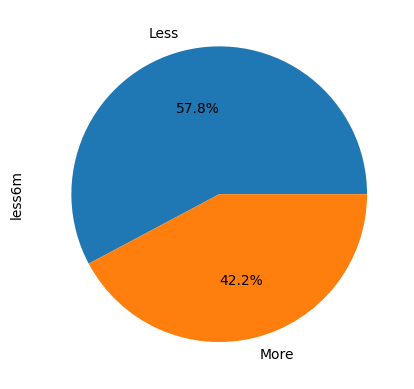

In [5]:
wow_players_cls["less6m"].value_counts().plot.pie(autopct="%.1f%%", labels=["Less","More"],labeldistance=1.12)

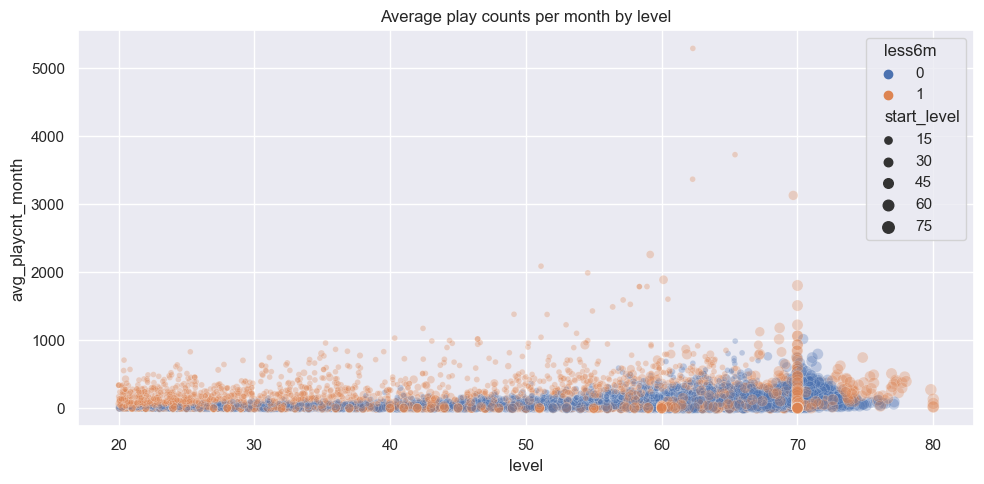

In [6]:
sns.set(rc={"figure.figsize":(10,5)})
sns.scatterplot(data=wow_players_cls, x="level", y="avg_playcnt_month", hue="less6m", size="start_level", alpha=0.3)
plt.title("Average play counts per month by level")
plt.tight_layout()
plt.savefig("./images/scatter_level_avgPlayCntMonth.png")

Drop 'playduration' column for training

In [7]:
df = wow_players_cls.drop("playduration", axis=1)
df.head()

,race,zone,numOfJoinedGuild,charclass,level,playcount,start_month,start_level,avg_playcnt_month,less6m
0,Orc,38,2,Hunter,63.127588,593,1,54,49.416667,0
1,Orc,43,2,Hunter,70.000000,1504,1,70,250.666667,1
2,Orc,31,1,Hunter,50.602446,550,7,29,110.000000,1
3,Orc,24,3,Rogue,69.983255,1710,1,69,142.500000,0
4,Orc,50,2,Hunter,70.000000,863,1,70,71.916667,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8618 entries, 0 to 29724
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   race               8618 non-null   object 
 1   zone               8618 non-null   int64  
 2   numOfJoinedGuild   8618 non-null   int64  
 3   charclass          8618 non-null   object 
 4   level              8618 non-null   float64
 5   playcount          8618 non-null   int64  
 6   start_month        8618 non-null   int64  
 7   start_level        8618 non-null   int64  
 8   avg_playcnt_month  8618 non-null   float64
 9   less6m             8618 non-null   int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 740.6+ KB


In [9]:
# col_transform = ColumnTransformer([
#     ("ohe1", OneHotEncoder( drop="if_binary"), ["race"]),
#     ("ohe2", OneHotEncoder( drop="if_binary"), ["charclass"]),
#     ("std_zone", StandardScaler(), ["zone"]),
#     ("std_lv", StandardScaler(), ["level"]),
#     ("std_startlv", StandardScaler(), ["start_level"]),
#     ("str_playcnt", StandardScaler(), ["playcount"])
# ])

col_transform = ColumnTransformer([
    ("ohe1", OneHotEncoder( drop="if_binary"), ["race"]),
    ("ohe2", OneHotEncoder( drop="if_binary"), ["charclass"]),
    ("std_zone", StandardScaler(), ["zone"]),
    ("poly_lv", PolynomialFeatures(), ["level"]),
    ("startlv", PolynomialFeatures(), ["start_level"]),
    ("playcnt", PolynomialFeatures(), ["playcount"])
    # ("monthcnt", StandardScaler(),['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
])

Create new column to indicate gamer who played less than six months

In [10]:
label = "less6m"
X = df.drop(label, axis=1)
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [11]:
def train_model(name, estimator, X_train, y_train, X_test, y_test):
    """
    Function to generate result for the each estimators
    """
    model = Pipeline([
        ("transformer", col_transform),
        ("estimator", estimator)
    ])
    start_time = time.time_ns()
    model.fit(X_train, y_train)
    duration = (time.time_ns() - start_time)/1000000000

    y_pred = model.predict(X_test)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc = roc_curve(y_test, y_pred)

    dis = RocCurveDisplay.from_predictions(y_test, y_pred)
    dis.figure_.suptitle(f"{name} ROC Curve")
    dis.figure_.savefig(f"./images/{name}_roc_curve.png")
    
    return model, score_train, score_test, precision, recall, roc, dis, duration

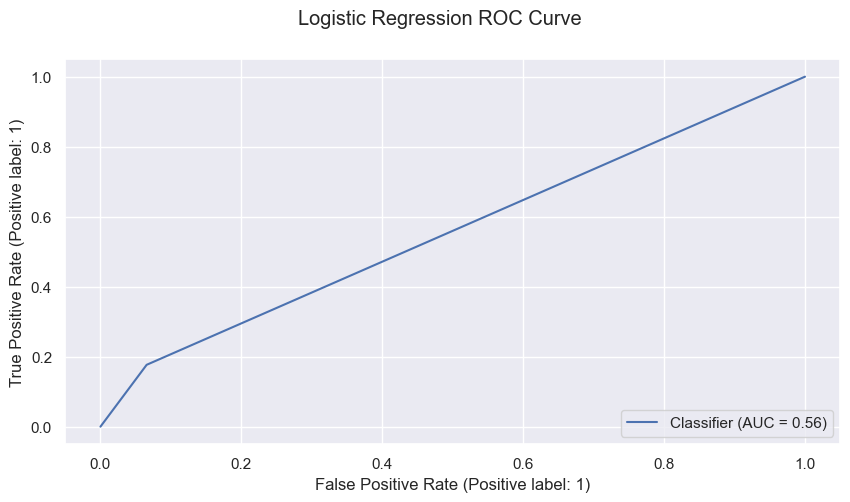

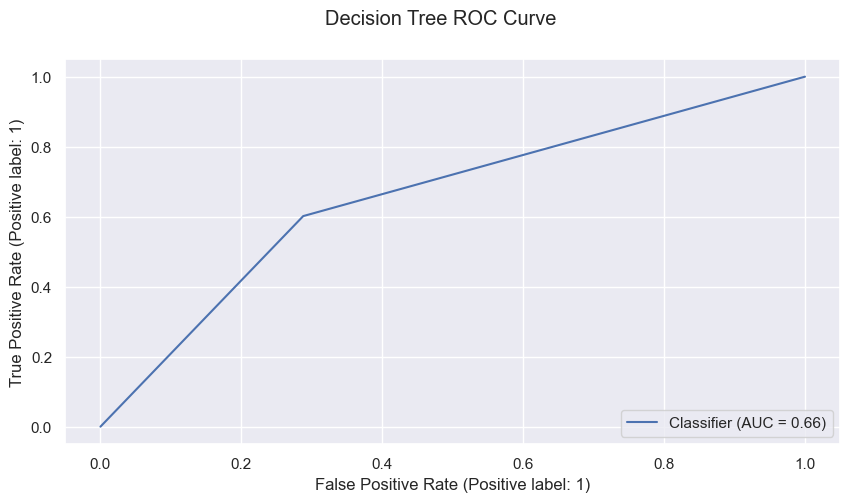

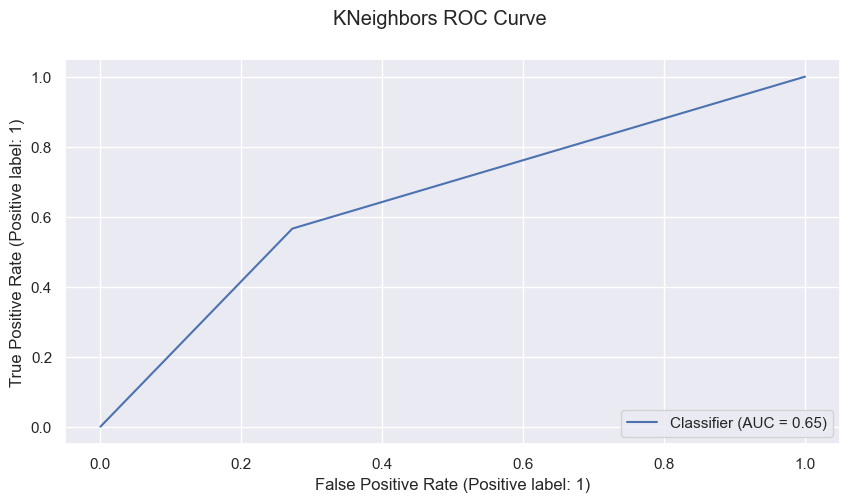

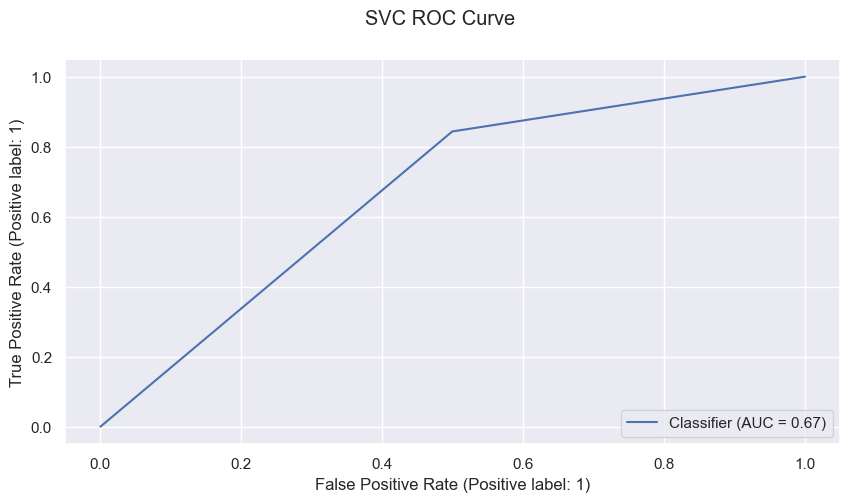

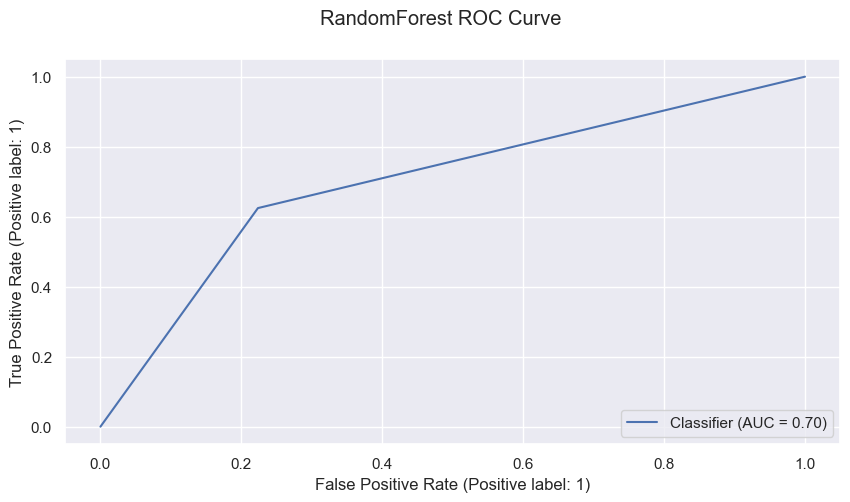

In [12]:
# initialize variables to collect result
trained_models = []
train_scores = []
test_scores = []
precisions = []
recalls = []
rocs = []
displays = []
durations = []

# Estimators
estimators = [LogisticRegression(), DecisionTreeClassifier(), KNeighborsClassifier(), SVC(), RandomForestClassifier()]
# Estimators name
estimator_names = ["Logistic Regression", "Decision Tree", "KNeighbors", "SVC", "RandomForest"]

for i, estimator in enumerate(estimators):
    model, score_train, score_test, precision, recall, roc, dis, duration = train_model(estimator_names[i], estimator, X_train, y_train, X_test, y_test)
    trained_models.append(model)
    train_scores.append(score_train)
    test_scores.append(score_test)
    precisions.append(precision)
    recalls.append(recall)
    rocs.append(roc)
    displays.append(dis)
    durations.append(duration)


Baseline results

In [13]:
results = {"estimator_name": estimator_names, "duration":durations ,"score_train": train_scores, "score_test": test_scores, "precision":precisions, "recall":recalls}
results_df = pd.DataFrame(results).set_index("estimator_name")
results_df

,duration,score_train,score_test,precision,recall
estimator_name,,,,,
Logistic Regression,0.052559,0.618037,0.614462,0.663230,0.176740
Decision Tree,0.052602,0.994198,0.665507,0.604416,0.601648
KNeighbors,0.018090,0.764257,0.659319,0.602927,0.565934
SVC,1.468787,0.629476,0.645398,0.552490,0.843407
RandomForest,0.676207,0.994198,0.712297,0.671260,0.624542


Hyperparameters Tunning

In [14]:
param_grid = {
    'estimator__penalty': ['l1', 'l2'],
    'estimator__C': [0.1, 1, 10, 100],
    'estimator__solver': ['liblinear', 'saga']
}

lr = Pipeline([
        ("transformer", col_transform),
        ("estimator", LogisticRegression())
    ])

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test data
best_lr = grid_search.best_estimator_
print(f"Test set accuracy: {best_lr.score(X_test, y_test)}")

Best hyperparameters: {'estimator__C': 10, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}
Test set accuracy: 0.7196442382057231


In [15]:
param_grid = {
    'estimator__n_estimators': [10, 50, 100, 200],
    'estimator__max_depth': [1, 3, 5, 7],
    'estimator__min_samples_split': [2, 4, 6],
    'estimator__min_samples_leaf': [1, 2, 3],
    'estimator__max_features': ['auto', 'sqrt', 'log2']
}

rfc = Pipeline([
        ("transformer", col_transform),
        ("estimator", RandomForestClassifier())
    ])

grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f"Best hyperparameters: {grid_search.best_params_}")

# Evaluate the best model on the test data
best_rfc = grid_search.best_estimator_
print(f"Test set accuracy: {best_rfc.score(X_test, y_test)}")

Best hyperparameters: {'estimator__max_depth': 7, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 50}
Test set accuracy: 0.7397525135344161


## End of notebook

SVC takes more than hours, the job didn't finish

In [16]:
# param_grid = {
#     'estimator__C': [0.1, 1, 10],
#     'estimator__gamma': [0.1, 1, 10],
#     'estimator__kernel': ['linear', 'rbf', 'poly']
# }

# svm = Pipeline([
#         ("transformer", col_transform),
#         ("estimator", SVC())
#     ])

# grid_search_svm = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the GridSearchCV object to the training data
# grid_search_svm.fit(X_train, y_train)

# # Print the best hyperparameters
# print(f"Best hyperparameters: {grid_search_svm.best_params_}")

# # Evaluate the best model on the test data
# best_svm = grid_search_svm.best_estimator_
# print(f"Test set accuracy: {best_svm.score(X_test, y_test)}")